<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
from tensorflow.keras.utils import to_categorical 
from matplotlib import pyplot as plt
import random

2023-07-12 14:13:28.190119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 14:13:28.655990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 14:13:29.958717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
device = tf.device("/GPU:0" if tf.test.is_gpu_available() else "/CPU:0")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-07-12 14:13:33.210721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 14:13:33.211994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 14:13:33.611480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
device

In [4]:
#image_dataset = np.load('./dataset/saved_images_masks_npy/low_exp/images/testimages.npy')
#labels = np.load('./dataset/saved_images_masks_npy//low_exp/masks/testmasks.npy')

image_dataset = np.load('./dataset/saved_images_masks_npy/images/imagesChunk1.npy')
labels = np.load('./dataset/saved_images_masks_npy/masks/masksChunk1.npy')

#image_dataset = image_dataset[:10]
#labels = labels[:10]

patch_len_x = 256
patch_len_y = 256

image_splits = []
label_splits = []

for record in range(image_dataset.shape[0]):
  print("record start", record)
  for ind_i in range(int(image_dataset.shape[1]/patch_len_x)):
    for ind_j in range(int(image_dataset.shape[2]/patch_len_y)):
            selected_patch = image_dataset[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            selected_mask = labels[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            image_splits.append(selected_patch)
            label_splits.append(selected_mask)

image_splits = np.concatenate(image_splits, axis=0)
label_splits = np.concatenate(label_splits, axis=0)

print("record end", record)

image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y)
label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y)

image_splits = image_splits[:50945]
label_splits = label_splits[:50945]

label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y, 1)
image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y, 1)



record start 0
record start 1
record start 2
record start 3
record start 4
record start 5
record start 6
record start 7
record start 8
record start 9
record start 10
record start 11
record start 12
record start 13
record start 14
record start 15
record start 16
record start 17
record start 18
record start 19
record start 20
record start 21
record start 22
record start 23
record start 24
record start 25
record start 26
record start 27
record start 28
record start 29
record start 30
record start 31
record start 32
record start 33
record start 34
record start 35
record start 36
record start 37
record start 38
record start 39
record start 40
record start 41
record start 42
record start 43
record start 44
record start 45
record start 46
record start 47
record start 48
record start 49
record end 49


In [5]:
print(label_splits.shape)
print(image_splits.shape)

(50945, 256, 256, 1)
(50945, 256, 256, 1)


In [6]:
total_classes = len(np.unique(label_splits))

In [15]:
total_classes

10

In [7]:
label_splits = tf.constant(label_splits)

In [8]:
label_splits.shape

TensorShape([50945, 256, 256, 1])

In [14]:
label_splits[0]

<tf.Tensor: shape=(256, 256, 1), dtype=int64, numpy=
array([[[2],
        [3],
        [3],
        ...,
        [0],
        [2],
        [2]],

       [[3],
        [3],
        [3],
        ...,
        [2],
        [2],
        [2]],

       [[3],
        [3],
        [3],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])>

In [16]:
import tensorflow as tf

# Example generator function
def batch_generator(data, batch_size):
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_data = data[start_idx:end_idx]

        # Convert batch_data to categorical matrix
        batch_categorical = tf.keras.utils.to_categorical(batch_data, num_classes=total_classes)

        yield batch_categorical

# Example data
input_data = tf.random.normal((50945, 256, 256, 1))  # Replace with your actual input data
batch_size = 1000  # Set an appropriate batch size

# Iterate through the batches
for batch in batch_generator(label_splits, batch_size):
    # Process each batch as needed
    # ...
    print(batch.shape)



(1000, 256, 256, 10)


(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)
(1000, 256, 256, 10)


KeyboardInterrupt: 

In [15]:
labels_categorical_dataset = to_categorical(label_splits, num_classes=total_classes)

: 

: 

In [ ]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [12]:
master_trianing_dataset = image_splits

In [13]:
master_trianing_dataset.shape

(945, 256, 256, 1)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 1)
(142, 256, 256, 1)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [17]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [18]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
1
6


# Deep learning part

In [19]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
     

In [20]:
from keras import backend as K


In [21]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [22]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [23]:
metrics = ["accuracy", jaccard_coef]


In [24]:

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
1
6


In [25]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [26]:
model = get_deep_learning_model()


In [27]:
# Uncomment below to see the model architecture
# model.get_config()

# Generating Loss function

In [28]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [29]:
#import segmentation_models as sm


In [30]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [31]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)


In [32]:
focal_loss = sm.losses.CategoricalFocalLoss()


In [33]:
'''dice_loss = sm.losses.DiceLoss(class_weights = weights)
dice_loss = sm.losses.DiceLoss(class_weights = weights)
total_loss = dice_loss + (1 * focal_loss)'''


'dice_loss = sm.losses.DiceLoss(class_weights = weights)\ndice_loss = sm.losses.DiceLoss(class_weights = weights)\ntotal_loss = dice_loss + (1 * focal_loss)'

In [34]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)


In [35]:
total_loss = dice_loss + (1 * focal_loss)


In [36]:
import tensorflow as tf


In [37]:
tf.keras.backend.clear_session()


In [38]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)


In [39]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [40]:
# To visualize the model
from keras.utils.vis_utils import plot_model

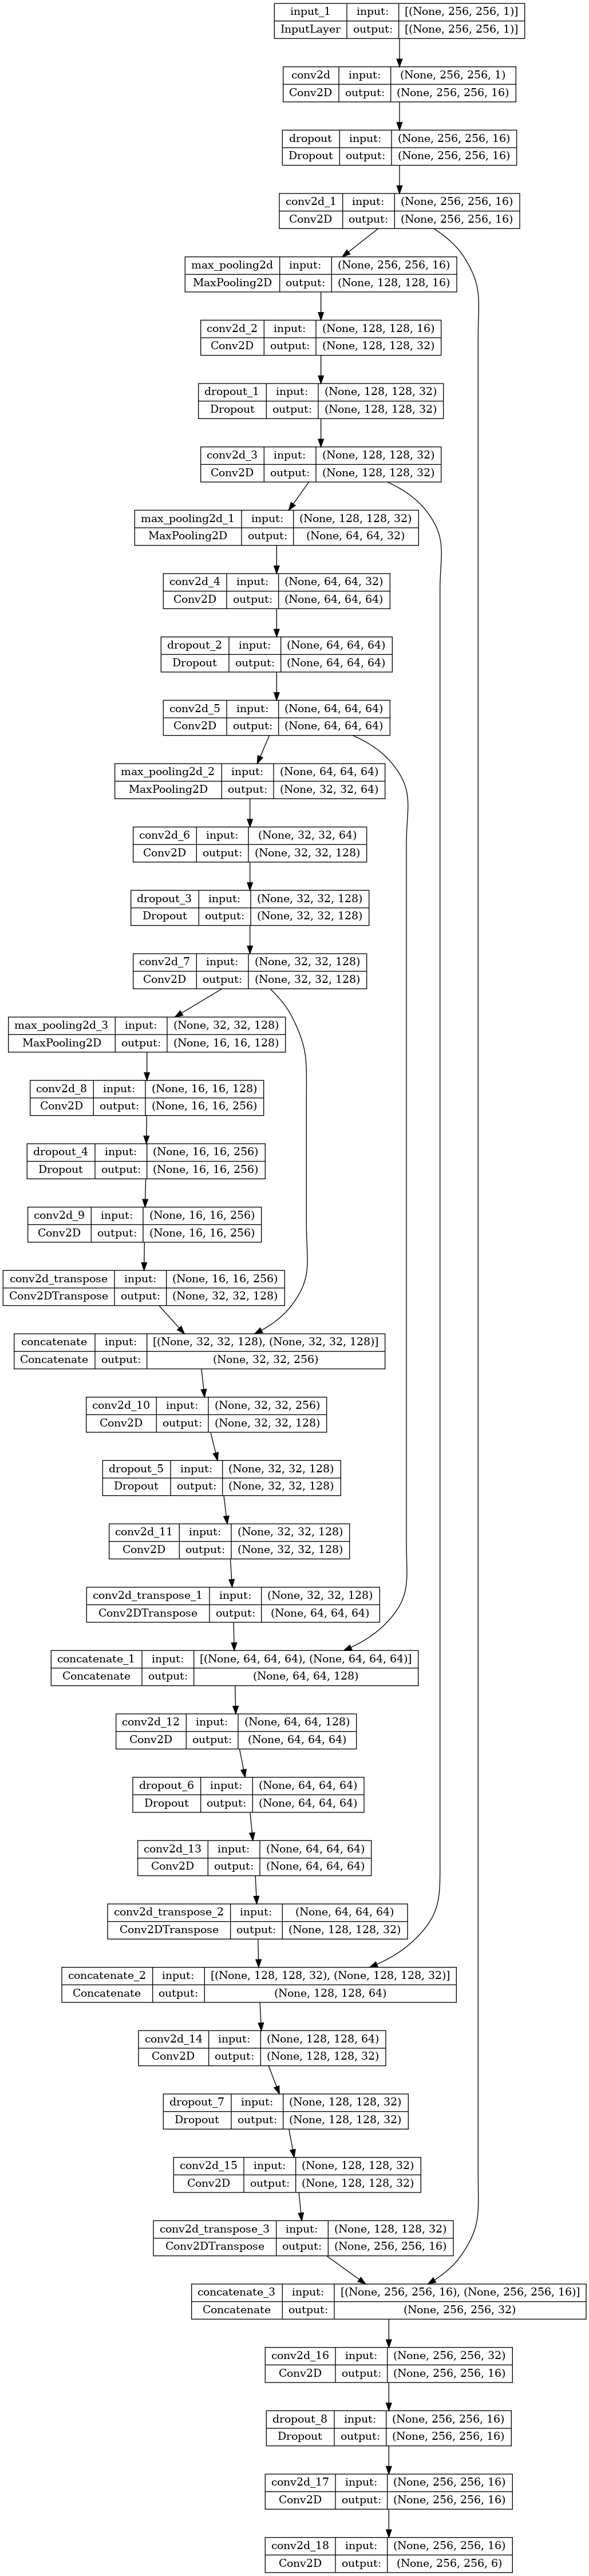

In [41]:
plot_model(model, to_file='satellite_model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
import keras
from IPython.display import clear_output
%matplotlib inline

In [43]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []
        self.fig = plt.figure()
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        #self.losses.append(logs.get("loss"))
        #self.val_losses.append(logs.get("val_loss"))

        self.jaccard_coef.append(logs.get("jaccard_coef"))
        self.val_jaccard_coef.append(logs.get("val_jaccard_coef"))

        self.i += 1

        clear_output(wait=True)
        #plt.plot(self.x, self.losses, label="loss")
        #plt.plot(self.x, self.val_losses, label="val_loss")

        plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
        plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

        plt.legend()
        plt.show();
    
plot_loss = PlotLoss()

In [44]:
# To get two plots
class PlotLossEx(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []
        self.fig = plt.figure()
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

        self.jaccard_coef.append(logs.get("jaccard_coef"))
        self.val_jaccard_coef.append(logs.get("val_jaccard_coef"))

        self.i += 1

        plt.figure(figsize=(14, 8))
        f, (graph1, graph2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)
        
        graph1.set_yscale('log')
        graph1.plot(self.x, self.losses, label="loss")
        graph1.plot(self.x, self.val_losses, label="val_loss")
        graph1.legend()

        graph2.set_yscale('log')
        graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
        graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

        graph2.legend()
        plt.show();
    
plot_loss = PlotLossEx()

<Figure size 1400x800 with 0 Axes>

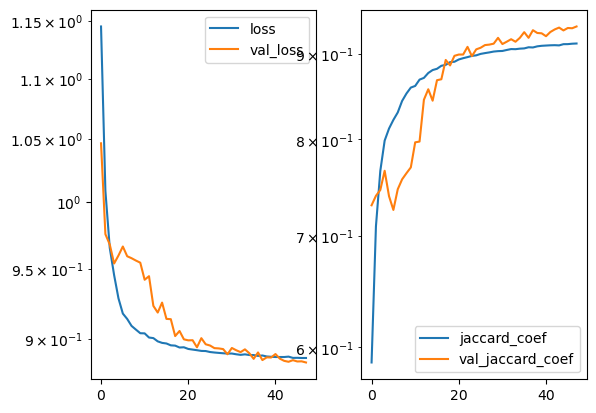

51/51 [==============================] - 2s 42ms/step - loss: 0.8869 - accuracy: 0.9605 - jaccard_coef: 0.9136 - val_loss: 0.8838 - val_accuracy: 0.9723 - val_jaccard_coef: 0.9353
Epoch 49/50
43/51 [========================>.....] - ETA: 0s - loss: 0.8868 - accuracy: 0.9612 - jaccard_coef: 0.9144

KeyboardInterrupt: 

In [45]:
# Training the model
#Two graph
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)

In [ ]:
'''
#One graph
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)'''

In [ ]:
history_a = model_history


In [ ]:
history_a.history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']
epochs = range(1, len(jaccard_coef) + 1)

plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Value')
plt.legend()
plt.show()


In [ ]:
model_history.params

In [42]:
# Saving the model

#model.save('./saved_model/sat_stelar_image_segmentation.h5')

In [41]:
# Loading the model


import keras.backend as K
import segmentation_models as sm

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # Compute dice loss using the DiceLoss class from segmentation_models
    dice_loss = sm.losses.DiceLoss(class_weights=weights)(y_true, y_pred)

    # Compute focal loss using the CategoricalFocalLoss class from segmentation_models
    focal_loss = sm.losses.CategoricalFocalLoss()(y_true, y_pred)

    # Combine the dice loss and focal loss
    total_loss = dice_loss + (1 * focal_loss)

    return total_loss

In [42]:
import keras
from keras import models

# Register the custom loss function
keras.losses.dice_loss_plus_1focal_loss = dice_loss_plus_1focal_loss
keras.metrics.jaccard_coef = jaccard_coef
# Load the saved model
model = models.load_model('./saved_model/sat_stelar_image_segmentation.h5')


# Comparing prediction results

##### using test images, using mask images and predicted result images

In [88]:
y_test_argmax = np.argmax(y_test, axis=3)
test_image_number = random.randint(0, len(X_test)-1)

test_image = X_test[test_image_number]
groud_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)

prediction = (model.predict(test_image_input))
predicted_image = np.argmax(prediction, axis=-1)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 48ms/step


In [89]:
groud_truth_image = groud_truth_image
predicted_image = predicted_image

color_map = {0: [255, 0, 0],        # Red
             1: [0, 255, 0],        # Green
             2: [0, 0, 255],        # Blue
             3: [255, 255, 0],      # Yellow
             4: [255, 165, 0],      # Orange
             5: [255, 0, 255],      # Magenta
             6: [0, 255, 255],      # Cyan
             7: [128, 0, 128],      # Violet
             8: [128, 128, 0],      # Olive
             9: [0, 128, 0],        # Dark Green
             10: [128, 0, 0]}       # Maroon


# Create color plot
groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
predicted_color_image = np.zeros(predicted_image.shape + (3,), dtype=np.uint8)
for i in range(groud_truth_image.shape[0]):
    for j in range(groud_truth_image.shape[1]):
        segment_id_gt = groud_truth_image[i, j]
        segment_id_pd = predicted_image[i, j]
        groud_truth_color_image[i, j] = color_map[segment_id_gt]
        predicted_color_image[i, j] = color_map[segment_id_pd]

In [90]:
test_image.min()

-961.0

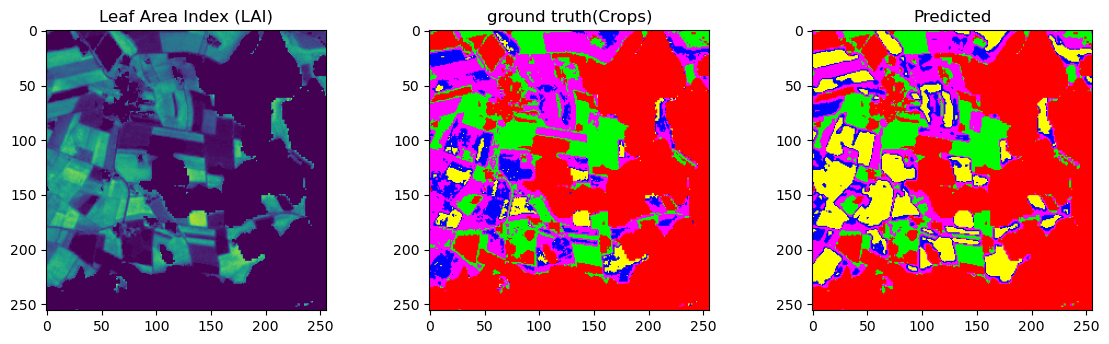

In [91]:
# Put all the 3 images together and display
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title('Leaf Area Index (LAI)')
test_image[test_image<0] = 0
plt.imshow(test_image)
plt.subplot(232)
plt.title('ground truth(Crops)')
#plt.imshow(groud_truth_image)
plt.imshow(groud_truth_color_image)
plt.subplot(233)
plt.title('Predicted')
#plt.imshow(predicted_image)
plt.imshow(predicted_color_image)

In [ ]:
#plots

# Class Imbalance Analysis

In [70]:
# Evaluation

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [71]:
y_test.shape, y_test.shape

((142, 256, 256, 6), (142, 256, 256, 6))

In [72]:
y_test_argmax = np.argmax(y_test, axis=3)


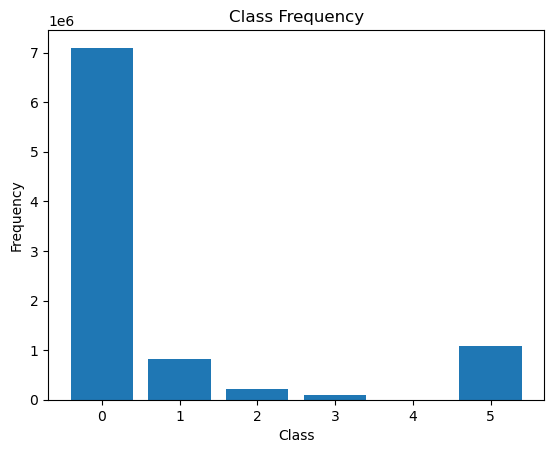

In [73]:
# get unique values in the y_test_argmax set and their frequency and plot the histogram
unique, counts = np.unique(y_test_argmax, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()




In [74]:
unique, counts = np.unique(y_test_argmax, return_counts=True)
dict(zip(unique, counts))


{0: 7097098, 1: 820531, 2: 213359, 3: 93609, 4: 286, 5: 1081229}

In [75]:
unique, counts

(array([0, 1, 2, 3, 4, 5]),
 array([7097098,  820531,  213359,   93609,     286, 1081229]))

# Segmentation Quality Measurements

## Intersection over Union (IoU)

In [82]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

In [77]:
test_image = X_test[test_image_number]
test_image.shape

(256, 256, 1)

In [78]:
X_test.shape

(142, 256, 256, 1)

In [89]:
no_classes = 6
crop = 0

all_class_iou = []
for crop in range(no_classes):
    all_iou = []
    for test_image_number in range(len(X_test)):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0


        iou = jaccard_score(img_true, img_pred, average='macro')

        print(iou)

        all_iou.append(iou)
    all_class_iou.append(all_iou)

1/1 [==============================] - 0s 48ms/step
0.9980890683879224
1/1 [==============================] - 0s 50ms/step
0.9969161858512033
1/1 [==============================] - 0s 44ms/step
0.9675818940263325
1/1 [==============================] - 0s 45ms/step
0.9976129582406145
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 46ms/step
1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 45ms/step
1.0
1/1 [==============================] - 0s 45ms/step
1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 42ms/step
0.9984876885718662
1/1 [==============================] - 0s 44ms/step
0.9980010191069701
1/1 [==============================] - 0s 45ms/step
1.0
1/1 [==============================] - 0s 42ms/step
0.9807273731191088
1/1 [==============================] - 0s 44ms/step
0.9

In [80]:
len(all_class_iou[0])

142

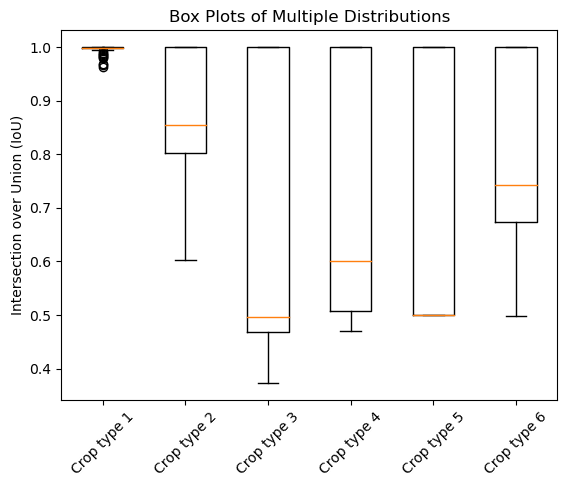

In [81]:
fig, ax = plt.subplots()
ax.boxplot(all_class_iou)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6'], rotation=45)

ax.set_ylabel('Intersection over Union (IoU)')

ax.set_title('Class-wise IoU')

plt.show()


In [99]:
#f1_sc = f1_score(img_true.flatten(), img_true.flatten(), zero_division=1)
f1_sc = f1_score(img_true.flatten(), img_true.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)


# F1 Score

In [101]:
#dice = f1_score(img_true.flatten(), img_pred.flatten(), zero_division=1)
#dice


no_classes = 6
#crop = 0

all_class_f1_sc = []
for crop in range(no_classes):
    all_f1_sc = []
    for test_image_number in range(len(X_test)):

        test_image = X_test[test_image_number]
        y_test_argmax = np.argmax(y_test, axis=3)
        groud_truth_image = y_test_argmax[test_image_number]
        test_image_input = np.expand_dims(test_image, axis=0)
        prediction = (model.predict(test_image_input))
        predicted_image = np.argmax(prediction, axis=-1)
        predicted_image = predicted_image[0,:,:]
        img_true=np.array(groud_truth_image).ravel()
        img_pred=np.array(predicted_image).ravel()

        for i in range(no_classes):
            if(i==crop):
                img_true[img_true==i]=100
                img_pred[img_pred==i]=100
            else:
                img_true[img_true==i]=0
                img_pred[img_pred==i]=0

        f1_sc = f1_score(img_true.flatten(), img_pred.flatten(), labels=[0, 100], pos_label=100, average='binary', zero_division=1)
        print(f1_sc)
        all_f1_sc.append(f1_sc)
    all_class_f1_sc.append(all_f1_sc)

1/1 [==============================] - 0s 50ms/step
0.999765199015575
1/1 [==============================] - 0s 47ms/step
0.9988383041686537
1/1 [==============================] - 0s 50ms/step
0.980448026994095
1/1 [==============================] - 0s 44ms/step
0.999651732852308
1/1 [==============================] - 0s 47ms/step
1.0
1/1 [==============================] - 0s 46ms/step
1.0
1/1 [==============================] - 0s 52ms/step
1.0
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 41ms/step
1.0
1/1 [==============================] - 0s 42ms/step
0.9994469957442715
1/1 [==============================] - 0s 49ms/step
0.998844681926493
1/1 [==============================] - 0s 47ms/step
1.0
1/1 [==============================] - 0s 41ms/step
0.9945440869556005
1/1 [==============================] - 0s 41ms/step
0.99959

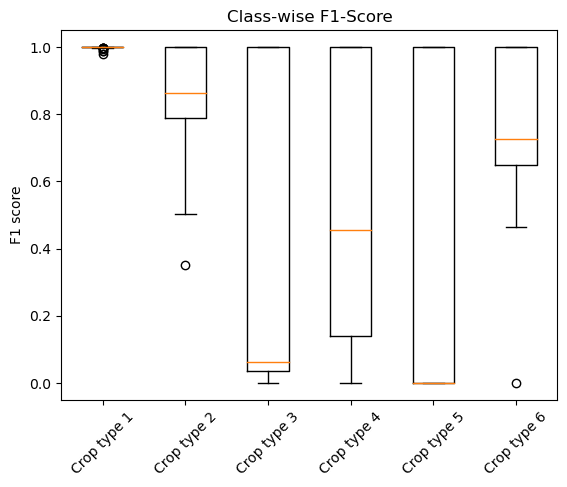

In [103]:
fig, ax = plt.subplots()
ax.boxplot(all_class_f1_sc)
ax.set_xticklabels(['Crop type 1', 'Crop type 2', 'Crop type 3', 'Crop type 4', 'Crop type 5', 'Crop type 6'], rotation=45)

ax.set_ylabel('F1 score')

ax.set_title('Class-wise F1-Score')

plt.show()


# Accuracy

